# all imports

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rnn_type = nn.LSTM # or nn.GRU

# parameters

In [3]:
# Choose subset of parts to train
keep_parts = slice(10)

epochs = 500 # ctrl-c to stop early
lr = 0.001

seq_len = 50
batch_size = 2

# Increase hidden_dim depending on number of parts being trained
# since it encodes forecast for all parts
hidden_dim = 512
layers = 2

# How many weeks to forecast
predict_steps = 50
# Forecast starts immediately after this slice of data
predict_input = slice(-predict_steps//2)

In [4]:
array = pd.read_csv("order-data.csv", skiprows=[0]).to_numpy()[keep_parts]

# test with sin wave

In [5]:
# Uncomment cell to test predicting sin waves to make sure everything is working...
# epochs = 10000
# lr = .001
# seq_len = 150
# batch_size = 1
# hidden_dim = 128
# layers = 2
# predict_steps = 100
# predict_input = slice(-seq_len, None)
# # Sequence needs to see at least a full wave length or results are bad
# array = np.array([[f'Wave {i}']+[np.sin(x + i*2*np.pi/2)*(i+1) for x in np.linspace(-1000, 1000, 10051)] for i in range(2)])

# transpose data
Extract part name from first column.  Transpose data so each column holds the quantities for a part.

In [6]:
part_names = array.T[0]
floats = np.array(array.T[1:], dtype='float32')
floats.shape

(104, 10)

# normalize quantities to be 0 - 1

In [7]:
min_ = floats.min(0)
max_ = floats.max(0)
normalize   = lambda values: (values - min_) / (max_ - min_)
unnormalize = lambda normalized: normalized * (max_ - min_) + min_

tensor = torch.from_numpy(normalize(floats))

# batch data
Notice how the columns line up. The hidden state output from 0,1,2,3,4 gets fed into sequence 5,6,7,8,9

In [8]:
def batch_data(items, seq_len, batch_size):
    num_batches = (len(items)-1) // (seq_len * batch_size)
    keep = num_batches*seq_len*batch_size
    discard = len(items) - keep - 1
    if discard: print(f"Discarding last {discard} items")
    features = items[:keep]   .view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    targets  = items[1:keep+1].view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    return [*zip(features, targets)]

for x, target in batch_data(torch.tensor(range(31)), seq_len=5, batch_size=3):
    print(x[:,:,0])

tensor([[ 0, 10, 20],
        [ 1, 11, 21],
        [ 2, 12, 22],
        [ 3, 13, 23],
        [ 4, 14, 24]], device='cuda:0')
tensor([[ 5, 15, 25],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 8, 18, 28],
        [ 9, 19, 29]], device='cuda:0')


In [9]:
# split = int(tensor.shape[0] * .8)
# train = batch_data(tensor[:split], seq_len, batch_size)
# valid = batch_data(tensor[split:], seq_len, batch_size)

# Until we get more data...
train = valid = batch_data(tensor, seq_len, batch_size)

Discarding last 3 items


# create RNN model
Using LSTM but GRU might be better

In [10]:
class RNN(nn.Module):
    def __init__(self, input_dim, dropout=.3):
        super().__init__()
        self.rnn = rnn_type(input_dim, hidden_dim, layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        y, hidden = self.rnn(x, hidden)
        y = y.view(-1, hidden_dim)
        y = self.dropout(y)
        y = self.fc(y)
        return y.view(x.shape), hidden

# define loss and optimizer

In [11]:
model = RNN(tensor.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train
Kernal -> Interrupt to end training early

In [12]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    hidden = None
    for x, target in train:
        if hidden is not None:
            if isinstance(hidden, tuple):
                hidden = tuple(h.detach() for h in hidden) # LSTM
            else:
                hidden = hidden.detach() # GRU

        y, hidden = model(x, hidden)
        loss = criterion(y, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        hidden = None
        for x, target in valid:
            y, hidden = model(x, hidden)
            loss = criterion(y, target)
            valid_loss += loss.item()

    print(f"Epoc {epoch}",
          f"train_loss={round(train_loss*1e5/len(train))}",
          f"valid_loss={round(valid_loss*1e5/len(valid))}")

Epoc 0 train_loss=2196 valid_loss=1894
Epoc 1 train_loss=1894 valid_loss=1961
Epoc 2 train_loss=1960 valid_loss=1884
Epoc 3 train_loss=1882 valid_loss=1855
Epoc 4 train_loss=1867 valid_loss=1862
Epoc 5 train_loss=1874 valid_loss=1867
Epoc 6 train_loss=1882 valid_loss=1861
Epoc 7 train_loss=1853 valid_loss=1848
Epoc 8 train_loss=1850 valid_loss=1833
Epoc 9 train_loss=1838 valid_loss=1821
Epoc 10 train_loss=1832 valid_loss=1812
Epoc 11 train_loss=1815 valid_loss=1806
Epoc 12 train_loss=1807 valid_loss=1799
Epoc 13 train_loss=1817 valid_loss=1788
Epoc 14 train_loss=1797 valid_loss=1773
Epoc 15 train_loss=1773 valid_loss=1756
Epoc 16 train_loss=1759 valid_loss=1739
Epoc 17 train_loss=1742 valid_loss=1720
Epoc 18 train_loss=1724 valid_loss=1699
Epoc 19 train_loss=1712 valid_loss=1674
Epoc 20 train_loss=1678 valid_loss=1646
Epoc 21 train_loss=1656 valid_loss=1613
Epoc 22 train_loss=1635 valid_loss=1576
Epoc 23 train_loss=1590 valid_loss=1536
Epoc 24 train_loss=1513 valid_loss=1493
Epoc 25 tr

Epoc 218 train_loss=320 valid_loss=220
Epoc 219 train_loss=238 valid_loss=240
Epoc 220 train_loss=318 valid_loss=288
Epoc 221 train_loss=356 valid_loss=294
Epoc 222 train_loss=312 valid_loss=297
Epoc 223 train_loss=359 valid_loss=248
Epoc 224 train_loss=315 valid_loss=277
Epoc 225 train_loss=318 valid_loss=274
Epoc 226 train_loss=311 valid_loss=277
Epoc 227 train_loss=316 valid_loss=278
Epoc 228 train_loss=302 valid_loss=254
Epoc 229 train_loss=287 valid_loss=253
Epoc 230 train_loss=291 valid_loss=232
Epoc 231 train_loss=276 valid_loss=239
Epoc 232 train_loss=282 valid_loss=237
Epoc 233 train_loss=263 valid_loss=222
Epoc 234 train_loss=256 valid_loss=221
Epoc 235 train_loss=263 valid_loss=217
Epoc 236 train_loss=268 valid_loss=221
Epoc 237 train_loss=294 valid_loss=219
Epoc 238 train_loss=249 valid_loss=225
Epoc 239 train_loss=257 valid_loss=212
Epoc 240 train_loss=254 valid_loss=209
Epoc 241 train_loss=260 valid_loss=211
Epoc 242 train_loss=249 valid_loss=193
Epoc 243 train_loss=244 v

Epoc 438 train_loss=112 valid_loss=72
Epoc 439 train_loss=112 valid_loss=70
Epoc 440 train_loss=115 valid_loss=74
Epoc 441 train_loss=121 valid_loss=71
Epoc 442 train_loss=99 valid_loss=69
Epoc 443 train_loss=99 valid_loss=71
Epoc 444 train_loss=117 valid_loss=73
Epoc 445 train_loss=94 valid_loss=77
Epoc 446 train_loss=121 valid_loss=71
Epoc 447 train_loss=100 valid_loss=83
Epoc 448 train_loss=100 valid_loss=84
Epoc 449 train_loss=105 valid_loss=82
Epoc 450 train_loss=103 valid_loss=89
Epoc 451 train_loss=106 valid_loss=75
Epoc 452 train_loss=112 valid_loss=84
Epoc 453 train_loss=126 valid_loss=80
Epoc 454 train_loss=110 valid_loss=76
Epoc 455 train_loss=115 valid_loss=81
Epoc 456 train_loss=117 valid_loss=79
Epoc 457 train_loss=128 valid_loss=82
Epoc 458 train_loss=123 valid_loss=78
Epoc 459 train_loss=122 valid_loss=70
Epoc 460 train_loss=115 valid_loss=80
Epoc 461 train_loss=110 valid_loss=94
Epoc 462 train_loss=144 valid_loss=100
Epoc 463 train_loss=112 valid_loss=100
Epoc 464 trai

# run data through model to create hidden state then generate predictions

In [13]:
input = tensor[predict_input]
output = torch.zeros(predict_steps, input.shape[1])
model.eval()
with torch.no_grad():
    x, _ = batch_data(input, len(input)-1, 1)[0]
    y, hidden = model(x, None)
    y = y[-1:, :, :]
    output[0] = y[0, 0, :]
    for i in range(1, predict_steps):
        y, hidden = model(y, hidden)
        output[i] = y[0, 0, :]

# unnormalize data

In [14]:
actual = tensor[predict_input.start:][:len(input) + len(output)]
actual = unnormalize(actual.numpy())
predict = unnormalize(output.cpu().numpy())
predict[:,0]

array([ 0.91418254,  1.9125273 , -1.1393296 , 22.971926  , -0.94798917,
       -1.694765  , -3.7500925 , 64.212265  ,  4.888489  , -0.72119606,
        1.4011915 , -1.4491804 , 37.290524  ,  3.2811651 ,  0.520889  ,
       -3.9997842 , 42.148495  , -3.9034889 , -1.8476149 , -1.7722616 ,
       18.895723  , 23.502226  ,  0.70025074, -0.5289877 ,  5.2547016 ,
       31.664415  , -1.5031306 ,  0.76753926,  0.34351727, 52.18183   ,
       -2.5418124 , -0.7393282 , -3.411759  , 53.87487   , -1.8589014 ,
       -1.70078   , -0.39427048,  0.1206566 , 33.998646  ,  2.1875815 ,
        1.0474278 , -1.9391875 , 27.925474  , -1.6236678 , -0.72284985,
       -1.3319453 , 44.513016  ,  7.5104437 ,  0.08558662, -0.23195277],
      dtype=float32)

# generate plots

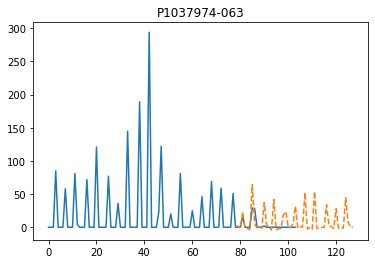

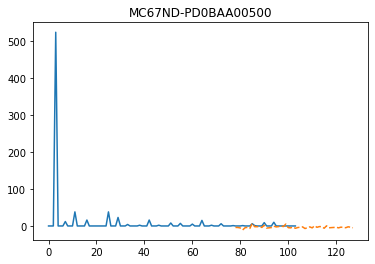

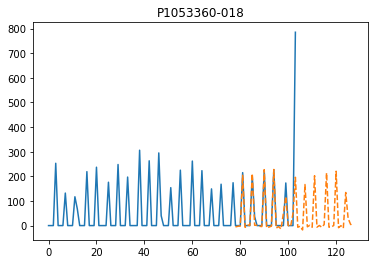

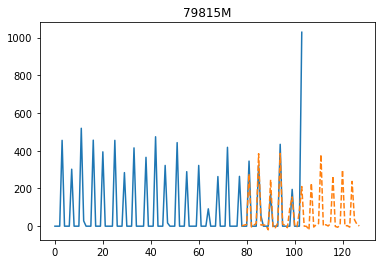

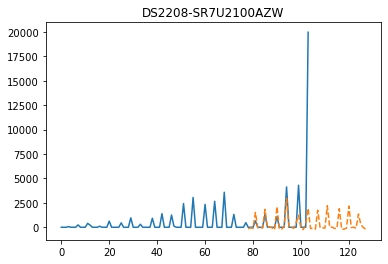

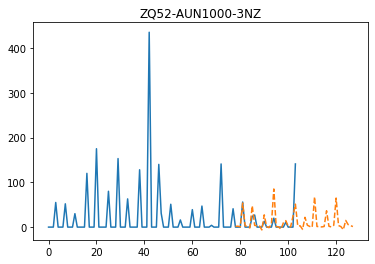

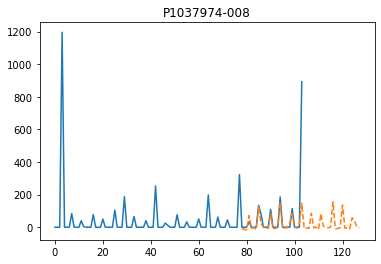

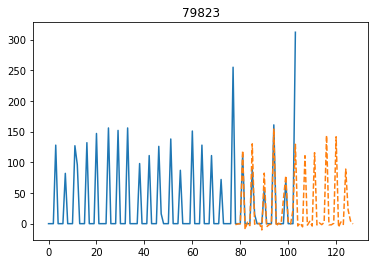

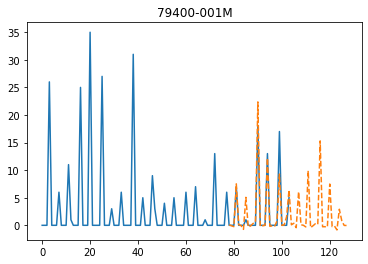

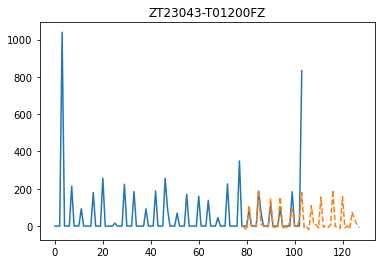

In [15]:
for p in range(actual.shape[1]):
    plt.title(part_names[p])
    plt.plot(range(len(actual)), actual[:, p])
    plt.plot(range(len(x), len(x) + len(predict)), predict[:, p], linestyle='--')
    plt.show()